<a href="https://colab.research.google.com/github/srivennela-128/OIB-SIP/blob/main/Project_5_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upgrade & install required libraries
!pip install -q imbalanced-learn xgboost shap joblib


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving creditcard.csv to creditcard.csv


In [ ]:
import pandas as pd

# replace filename if needed (e.g., 'creditcard.csv')
df = pd.read_csv('creditcard.csv')

print("✅ Data Loaded Successfully!")
print(df.shape)
df.head()


✅ Data Loaded Successfully!
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Nulls:
 False
Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


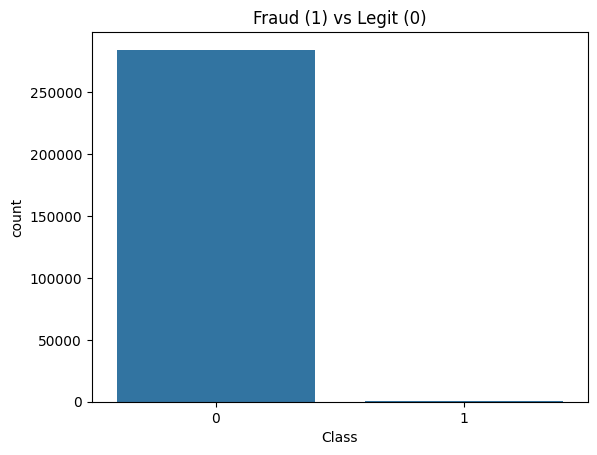

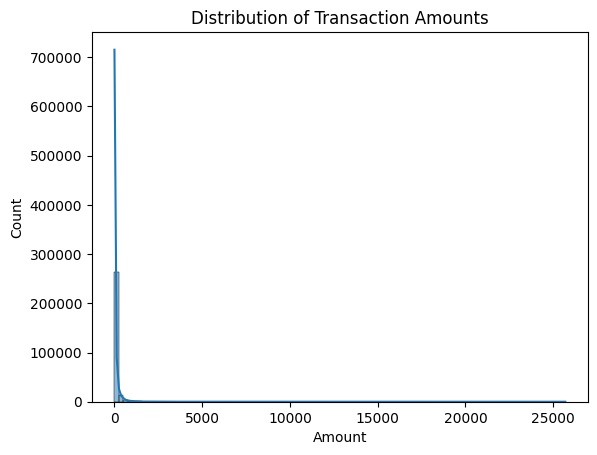

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Nulls:\n", df.isnull().sum().any())
print("Class Distribution:\n", df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Fraud (1) vs Legit (0)")
plt.show()

sns.histplot(df['Amount'], bins=100, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (227845, 30)
Test shape : (56962, 30)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# scale only Time & Amount
num_cols = ['Time', 'Amount']
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='passthrough'
)

smote = SMOTE(random_state=42)


In [ ]:
# Use only 20,000 samples for quick training
sample_df = df.sample(20000, random_state=42)
X = sample_df.drop('Class', axis=1)
y = sample_df['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, None]
}

pipe = Pipeline([
    ('clf', RandomForestClassifier())
])

rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

rs.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier())]),
                   param_distributions={'clf__max_depth': [5, 10, None],
                                        'clf__n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [ ]:
pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1))
])
pipe.fit(X_train, y_train)
best_model = pipe


In [ ]:
from xgboost import XGBClassifier

pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,   # balances classes
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42))
])

pipe.fit(X_train, y_train)
best_model = pipe


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Average Precision (PR AUC): 0.7164318479685451
ROC AUC: 0.9185717863403813

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3993
           1       0.71      0.71      0.71         7

    accuracy                           1.00      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       1.00      1.00      1.00      4000



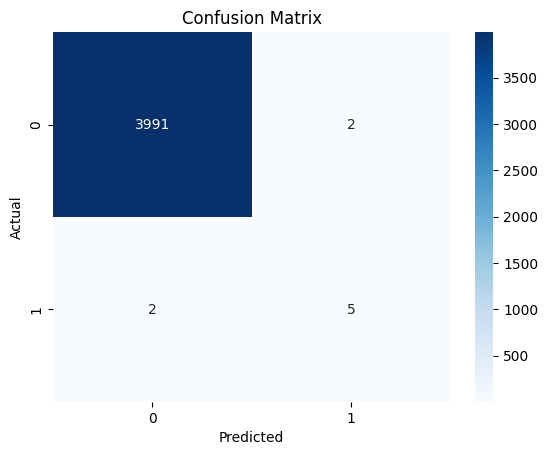

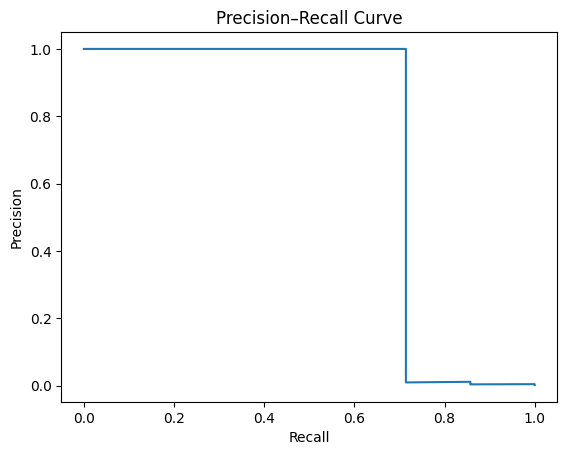

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score, precision_recall_curve

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [ ]:
import joblib

joblib.dump(best_model, "credit_fraud_model.joblib")
print("Model saved!")

from google.colab import files
files.download("credit_fraud_model.joblib")


Model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>